## Case Study 1: Transportation Problem

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 47.7 MB/s eta 0:00:00


In [ ]:
import pulp as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create the optimization model
model = pl.LpProblem("Transportation_Problem", pl.LpMinimize)

# Define sources and destinations
sources = ["Warehouse_A", "Warehouse_B", "Warehouse_C"]
destinations = ["Store_1", "Store_2", "Store_3", "Store_4", "Store_5"]

# Supply at each source
supply = {
    "Warehouse_A": 150,
    "Warehouse_B": 200,
    "Warehouse_C": 250
}

# Demand at each destination
demand = {
    "Store_1": 100,
    "Store_2": 90,
    "Store_3": 120,
    "Store_4": 110,
    "Store_5": 130
}

# Cost of shipping from each source to each destination
costs = {
    ("Warehouse_A", "Store_1"): 10,
    ("Warehouse_A", "Store_2"): 8,
    ("Warehouse_A", "Store_3"): 15,
    ("Warehouse_A", "Store_4"): 12,
    ("Warehouse_A", "Store_5"): 9,
    ("Warehouse_B", "Store_1"): 9,
    ("Warehouse_B", "Store_2"): 7,
    ("Warehouse_B", "Store_3"): 10,
    ("Warehouse_B", "Store_4"): 8,
    ("Warehouse_B", "Store_5"): 11,
    ("Warehouse_C", "Store_1"): 11,
    ("Warehouse_C", "Store_2"): 14,
    ("Warehouse_C", "Store_3"): 7,
    ("Warehouse_C", "Store_4"): 10,
    ("Warehouse_C", "Store_5"): 8
}

In [ ]:
# Decision variables - how much to ship from each source to each destination
shipments = {}
for s in sources:
    for d in destinations:
        shipments[(s, d)] = pl.LpVariable(f"Ship_{s}_to_{d}", lowBound=0, cat='Continuous')

# Objective function - minimize total shipping cost
model += pl.lpSum([shipments[(s, d)] * costs[(s, d)] for s in sources for d in destinations]), "Total_Cost"

# Supply constraints
for s in sources:
    model += pl.lpSum([shipments[(s, d)] for d in destinations]) <= supply[s], f"Supply_{s}"

# Demand constraints
for d in destinations:
    model += pl.lpSum([shipments[(s, d)] for s in sources]) == demand[d], f"Demand_{d}"

# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total Cost: ${pl.value(model.objective)}")

Status: Optimal
Total Cost: $4390.0


In [ ]:
# Create a shipping plan dataframe
shipping_plan = pd.DataFrame(index=sources, columns=destinations)
for s in sources:
    for d in destinations:
        # Convert the shipment value to float explicitly:
        shipping_plan.loc[s, d] = float(shipments[(s, d)].value())

print("\nShipping Plan:")
print(shipping_plan)


Shipping Plan:
            Store_1 Store_2 Store_3 Store_4 Store_5
Warehouse_A    10.0    90.0     0.0     0.0     0.0
Warehouse_B    90.0     0.0     0.0   110.0     0.0
Warehouse_C     0.0     0.0   120.0     0.0   130.0


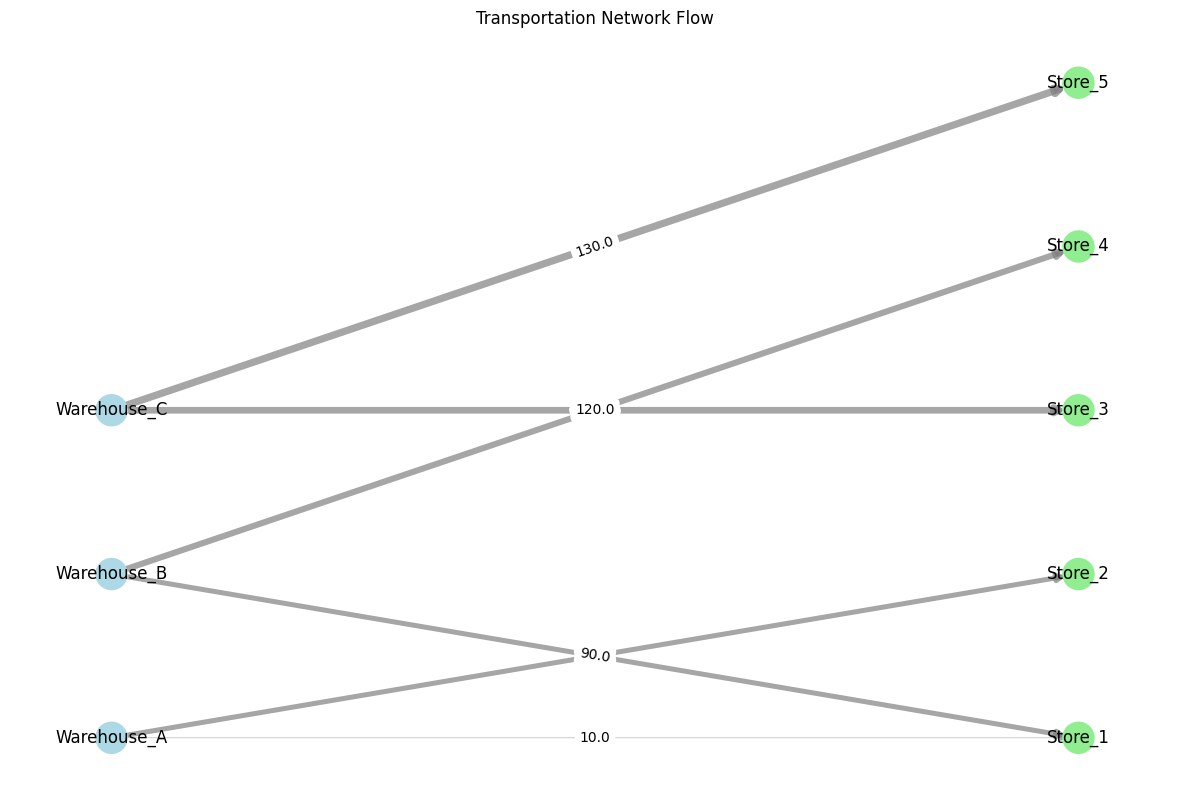

In [ ]:
# Create network diagram
import networkx as nx

G = nx.DiGraph()

# Add nodes
for s in sources:
    G.add_node(s, node_type='source')
for d in destinations:
    G.add_node(d, node_type='destination')

# Add edges with weights
for s in sources:
    for d in destinations:
        ship_amount = shipments[(s, d)].value()
        if ship_amount > 0:
            G.add_edge(s, d, weight=ship_amount)

# Plot
plt.figure(figsize=(12, 8))
pos = {**{s: (0, i) for i, s in enumerate(sources)},
       **{d: (1, i) for i, d in enumerate(destinations)}}

node_colors = []
for node in G.nodes():
    if node in sources:
        node_colors.append('lightblue')
    else:
        node_colors.append('lightgreen')

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_labels(G, pos)

# Draw edges with varying widths based on shipping amount
for s, d, data in G.edges(data=True):
    width = data['weight'] / 25  # Scale for better visualization
    nx.draw_networkx_edges(G, pos, edgelist=[(s, d)], width=width, alpha=0.7, edge_color='gray')

edge_labels = {(s, d): f"{data['weight']:.1f}" for s, d, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Transportation Network Flow")
plt.axis('off')
plt.tight_layout()
plt.show()

## Case Study 2: Cutting Stock Problem

In [ ]:
import pulp as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the optimization model
model = pl.LpProblem("Cutting_Stock_Problem", pl.LpMinimize)

# Parameters
stock_length = 100  # Length of raw material stock
item_lengths = [25, 35, 40, 50, 60]  # Lengths of items to be cut
demands = [50, 30, 20, 40, 10]  # Number of each item needed

In [ ]:
# Generate all feasible cutting patterns
def generate_patterns(stock_length, item_lengths):
    """Generate all feasible cutting patterns"""
    patterns = []

    def backtrack(remaining_length, current_pattern, start_idx):
        patterns.append(current_pattern[:])

        for i in range(start_idx, len(item_lengths)):
            if remaining_length >= item_lengths[i]:
                current_pattern[i] += 1
                backtrack(remaining_length - item_lengths[i], current_pattern, i)
                current_pattern[i] -= 1

    backtrack(stock_length, [0] * len(item_lengths), 0)

    return patterns

patterns = generate_patterns(stock_length, item_lengths)

# Filter out patterns that are too wasteful (optional)
max_waste = 20  # Maximum acceptable waste
filtered_patterns = []
for pattern in patterns:
    used_length = sum(pattern[i] * item_lengths[i] for i in range(len(item_lengths)))
    waste = stock_length - used_length
    if waste <= max_waste:
        filtered_patterns.append(pattern)

patterns = filtered_patterns

In [ ]:
# Create decision variables - how many times to use each pattern
x = {}
for j in range(len(patterns)):
    x[j] = pl.LpVariable(f"Pattern_{j}", lowBound=0, cat='Integer')

# Objective function - minimize number of stock pieces used
model += pl.lpSum([x[j] for j in range(len(patterns))]), "Minimize_Stock_Used"

# Constraints - meet demand for each item
for i in range(len(item_lengths)):
    model += pl.lpSum([patterns[j][i] * x[j] for j in range(len(patterns))]) >= demands[i], f"Meet_Demand_{i}"

In [ ]:
# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total stock pieces needed: {pl.value(model.objective)}")

# Get the solution
pattern_counts = []
for j in range(len(patterns)):
    count = x[j].value()
    if count > 0:
        print(f"Pattern {j}: {patterns[j]} used {count} times")
        pattern_counts.append((patterns[j], count))

Status: Optimal
Total stock pieces needed: 58.0
Pattern 0: [4, 0, 0, 0, 0] used 8.0 times
Pattern 4: [1, 2, 0, 0, 0] used 10.0 times
Pattern 5: [1, 1, 1, 0, 0] used 10.0 times
Pattern 11: [0, 0, 1, 0, 1] used 10.0 times
Pattern 12: [0, 0, 0, 2, 0] used 20.0 times


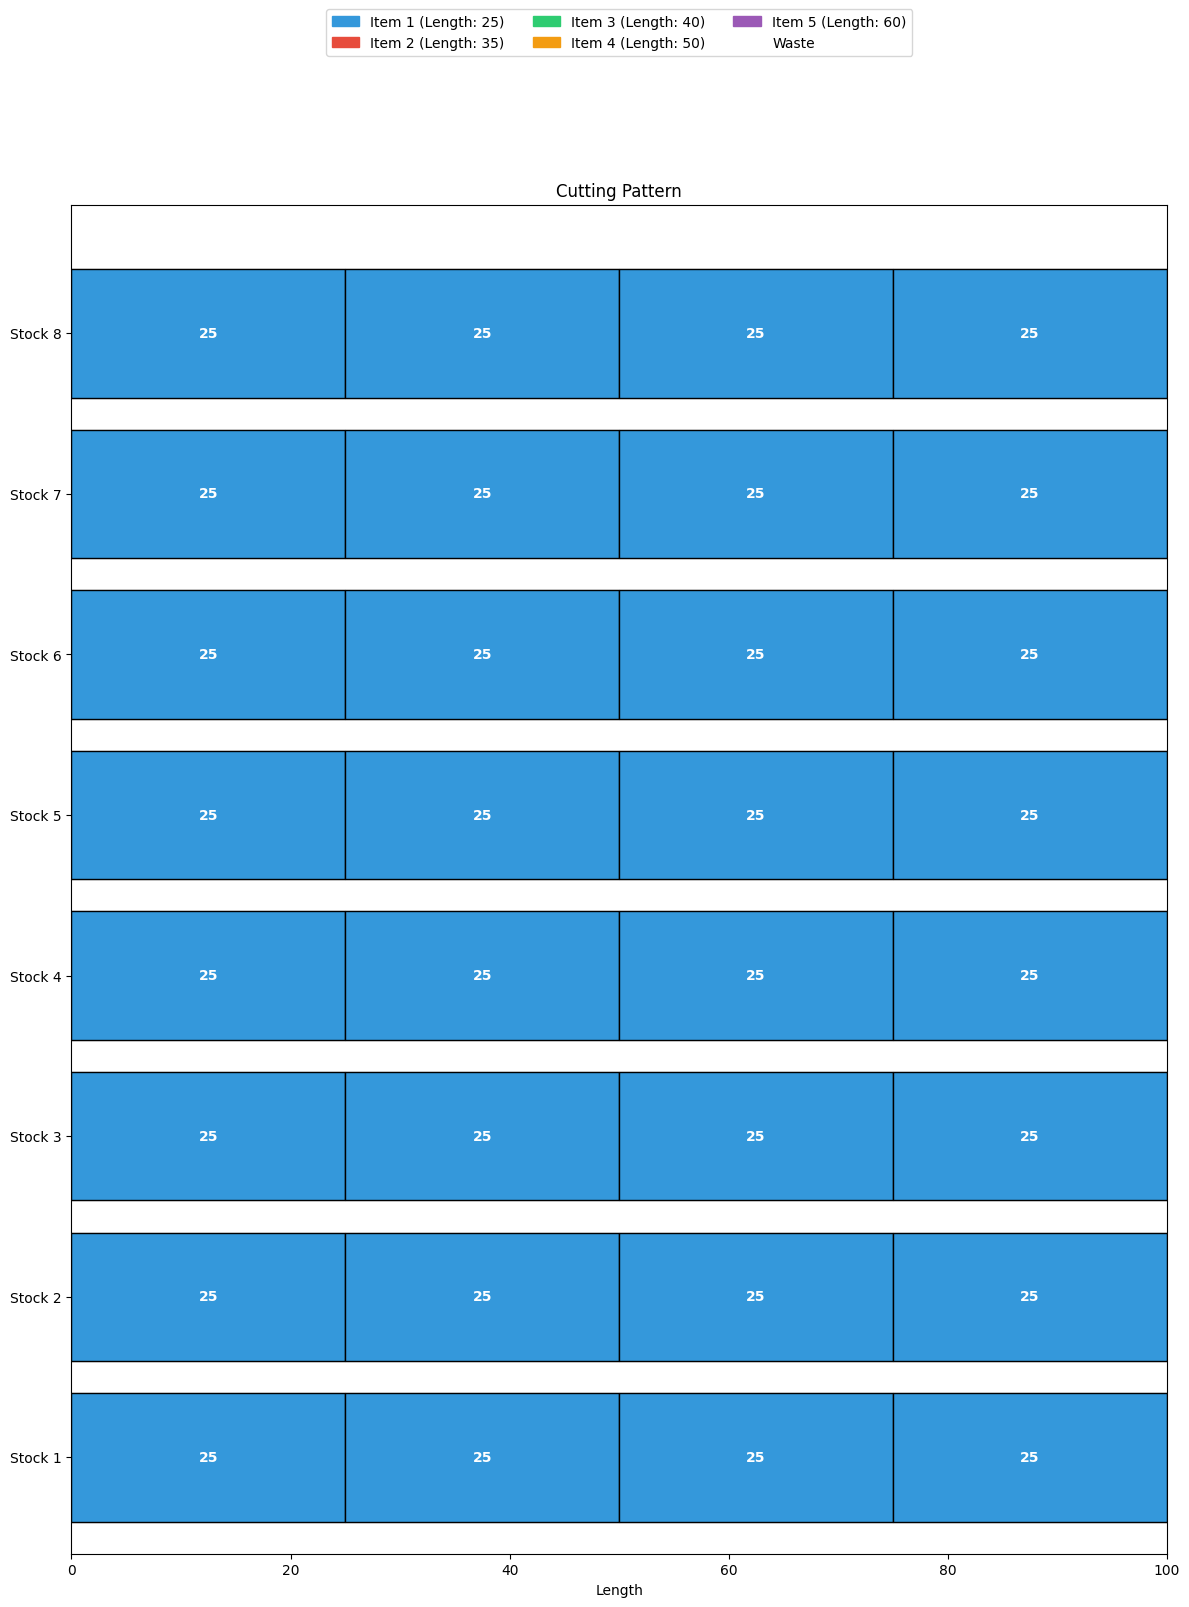

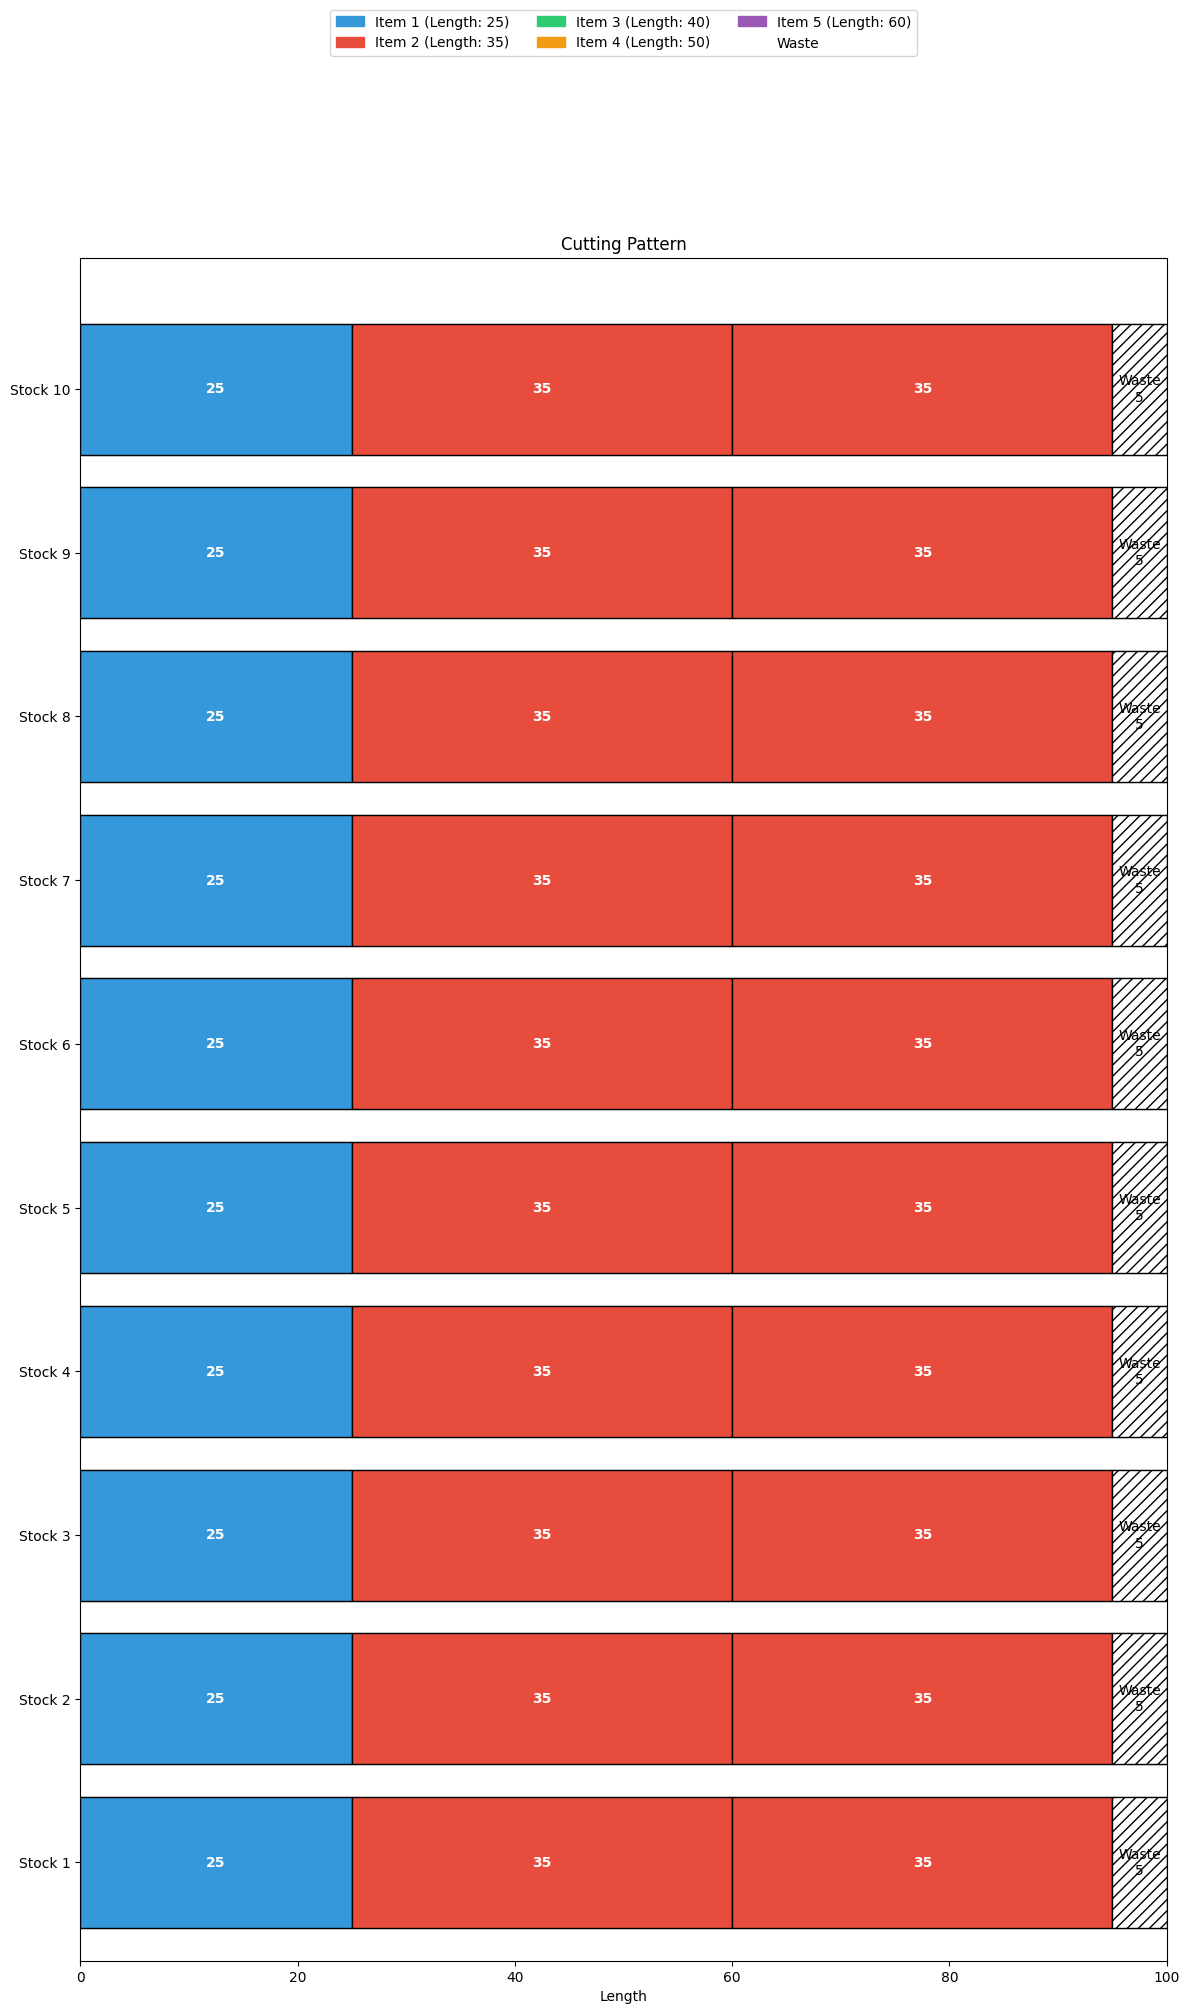

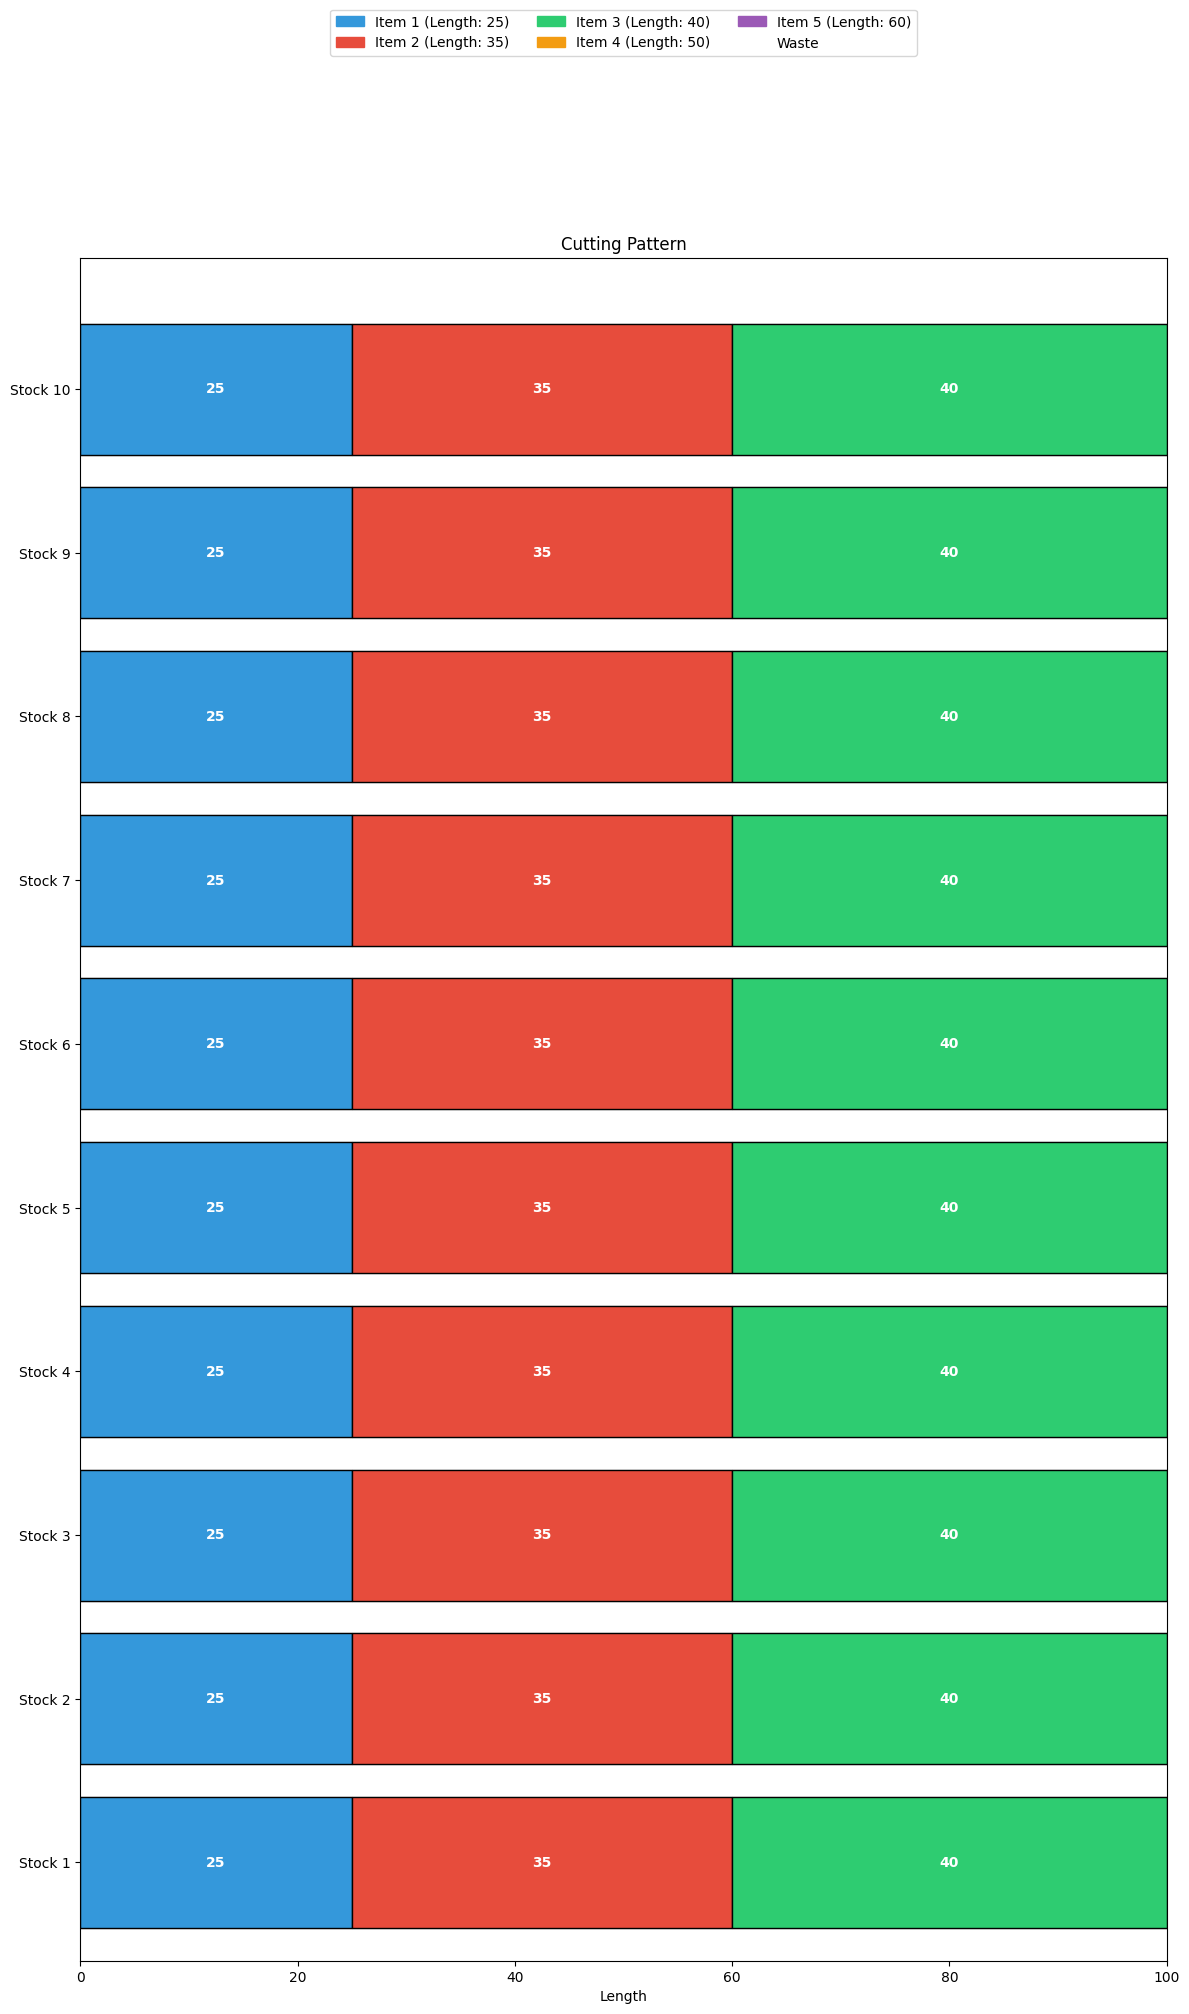

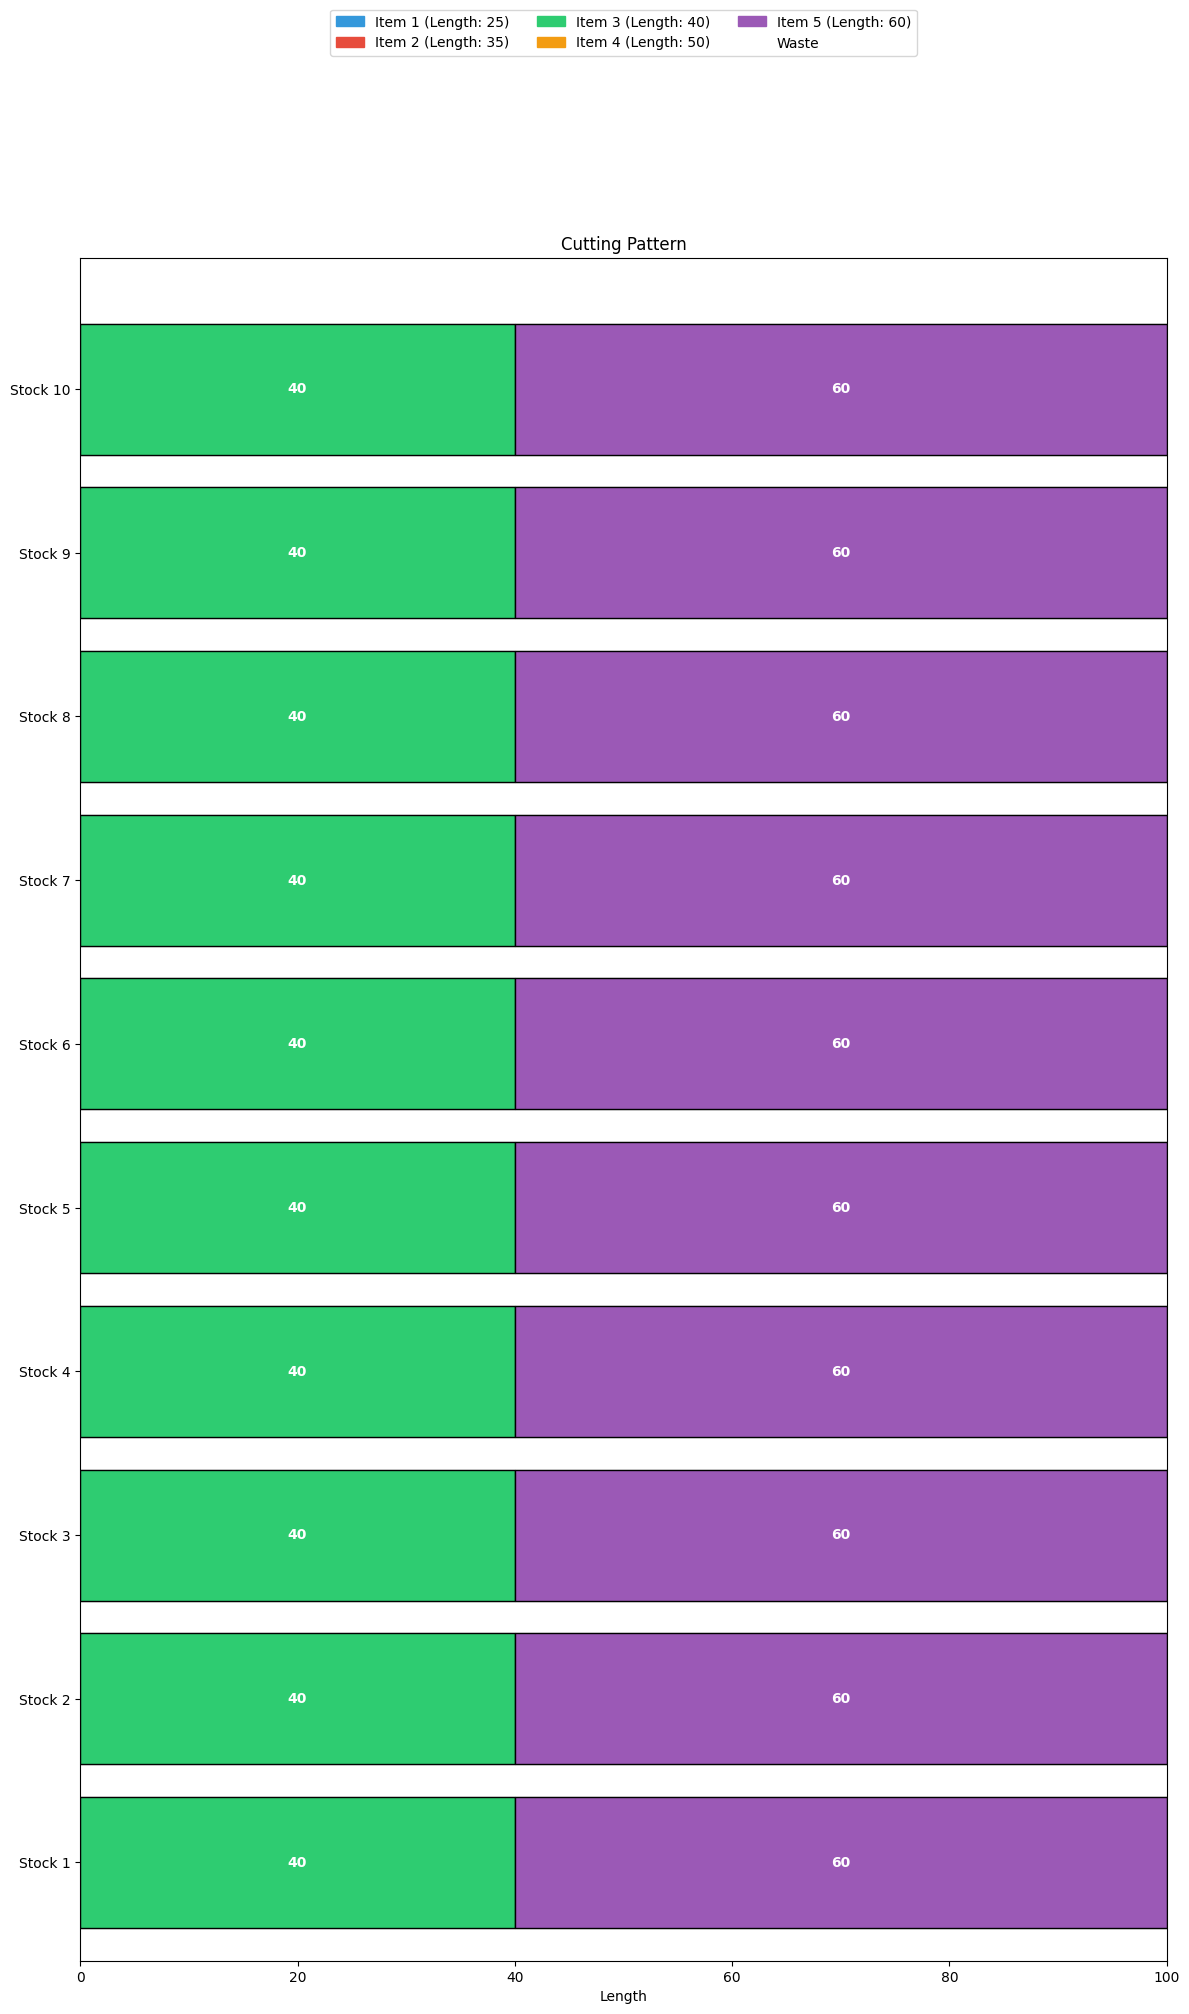

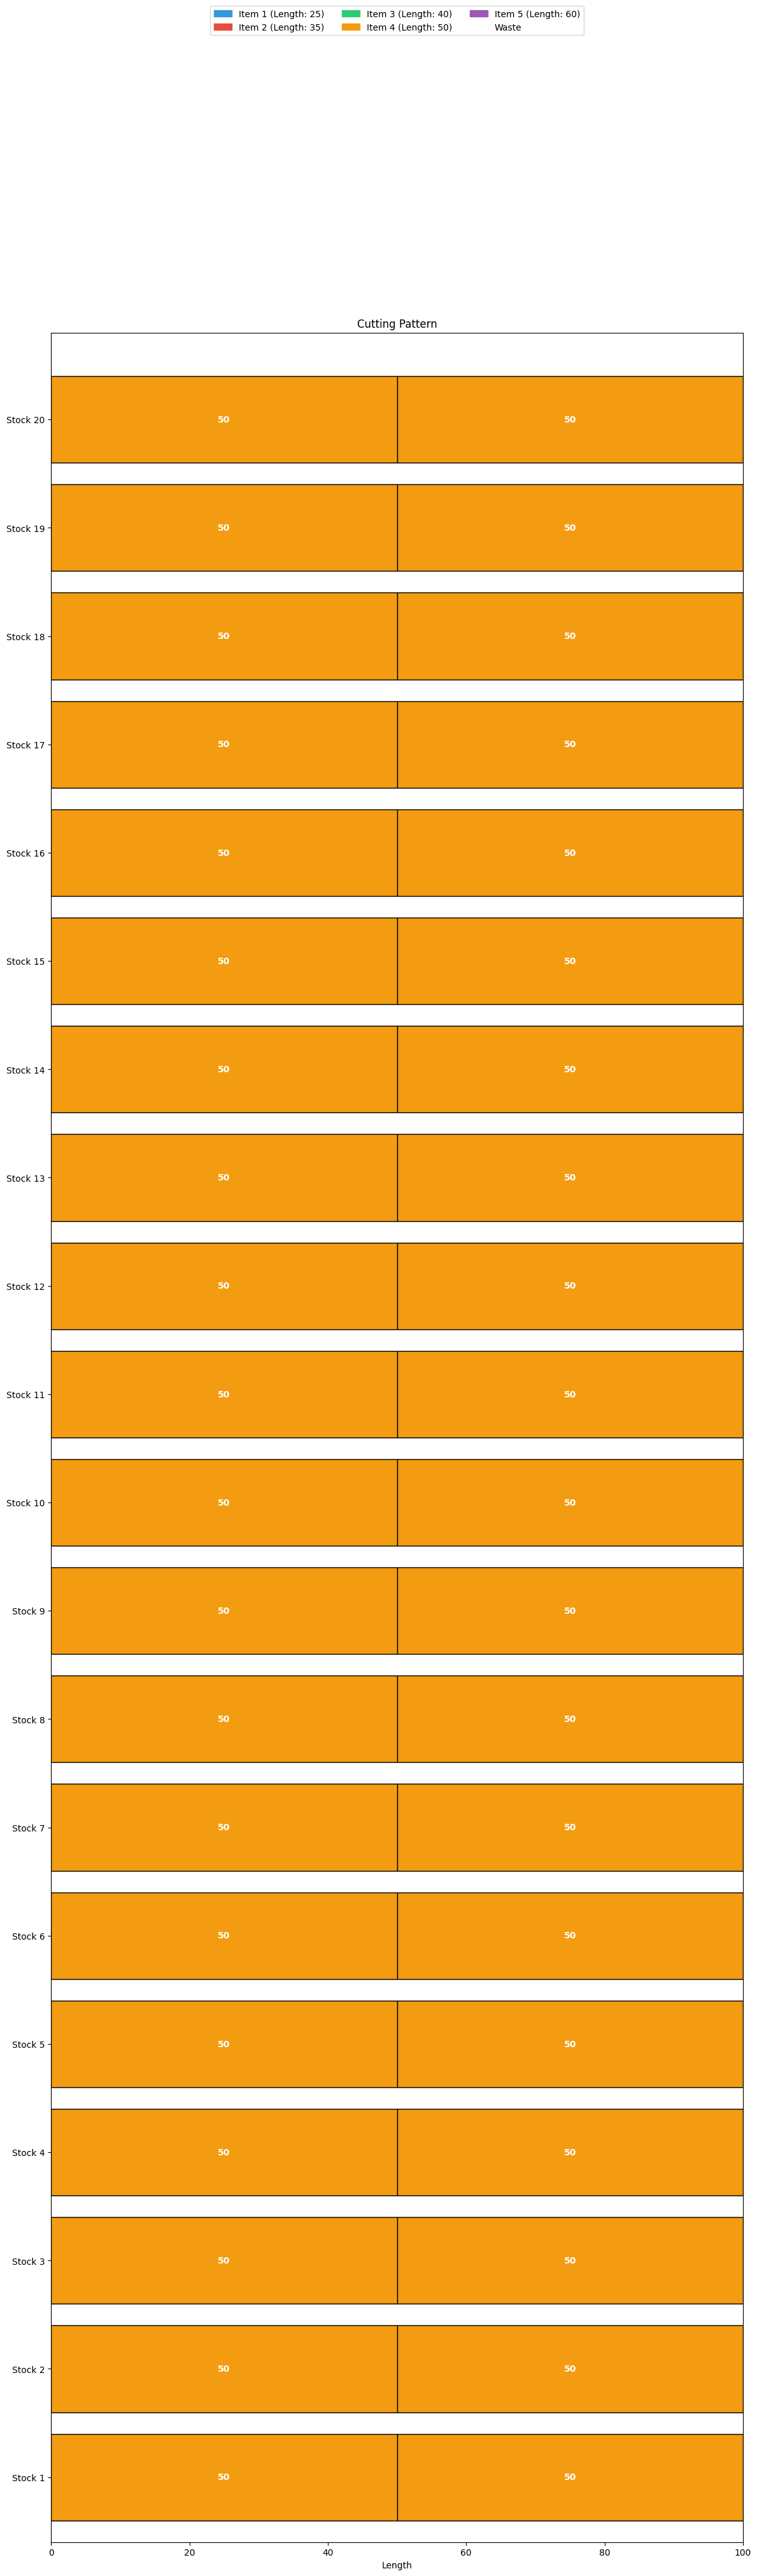

In [ ]:
# Visualize the cutting patterns
def visualize_cutting_pattern(pattern, count, stock_length, item_lengths):
    item_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#d35400']

    fig, ax = plt.subplots(figsize=(12, 2 * count))

    for i in range(int(count)):
        current_position = 0
        rect = patches.Rectangle((0, i), stock_length, 0.8, linewidth=1, edgecolor='black', facecolor='gray', alpha=0.3)
        ax.add_patch(rect)

        for j, item_count in enumerate(pattern):
            for _ in range(int(item_count)):
                item_length = item_lengths[j]
                rect = patches.Rectangle(
                    (current_position, i), item_length, 0.8,
                    linewidth=1, edgecolor='black', facecolor=item_colors[j % len(item_colors)]
                )
                ax.add_patch(rect)

                # Add text in the middle of each rectangle
                ax.text(
                    current_position + item_length/2, i + 0.4,
                    f"{item_length}",
                    ha='center', va='center', color='white', fontweight='bold'
                )

                current_position += item_length

        # Show waste
        waste = stock_length - sum(pattern[j] * item_lengths[j] for j in range(len(item_lengths)))
        if waste > 0:
            rect = patches.Rectangle(
                (current_position, i), waste, 0.8,
                linewidth=1, edgecolor='black', facecolor='white', hatch='///'
            )
            ax.add_patch(rect)
            ax.text(
                current_position + waste/2, i + 0.4,
                f"Waste\n{waste}",
                ha='center', va='center', color='black'
            )

    # Add a legend
    legend_patches = []
    for i in range(len(item_lengths)):
        legend_patches.append(patches.Patch(
            color=item_colors[i % len(item_colors)],
            label=f"Item {i+1} (Length: {item_lengths[i]})"
        ))
    legend_patches.append(patches.Patch(color='white', hatch='///', label='Waste'))

    ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    ax.set_xlim(0, stock_length)
    ax.set_ylim(-0.2, count + 0.2)
    ax.set_yticks([i + 0.4 for i in range(int(count))])
    ax.set_yticklabels([f"Stock {i+1}" for i in range(int(count))])
    ax.set_xlabel('Length')
    ax.set_title(f'Cutting Pattern')

    return fig, ax

for i, (pattern, count) in enumerate(pattern_counts):
    fig, ax = visualize_cutting_pattern(pattern, count, stock_length, item_lengths)
    plt.tight_layout()
    plt.show()

## Case Study 3: Facility Location Problem

In [ ]:
import pulp as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create the optimization model
model = pl.LpProblem("Facility_Location", pl.LpMinimize)

# Define potential facility locations and customer locations
n_facilities = 5
n_customers = 20

# Generate random coordinates for visualization
np.random.seed(42)
facility_coords = np.random.rand(n_facilities, 2) * 100
customer_coords = np.random.rand(n_customers, 2) * 100

In [ ]:
# Calculate distances between facilities and customers
distances = {}
for i in range(n_facilities):
    for j in range(n_customers):
        # Euclidean distance
        distances[(i, j)] = np.sqrt(
            (facility_coords[i, 0] - customer_coords[j, 0])**2 +
            (facility_coords[i, 1] - customer_coords[j, 1])**2
        )

# Customer demand
demands = np.random.randint(10, 100, size=n_customers)

# Facility fixed costs and capacities
fixed_costs = np.random.randint(500, 1500, size=n_facilities)
capacities = np.random.randint(250, 500, size=n_facilities)

# Decision variables
# Binary variable for whether to open facility i
y = {}
for i in range(n_facilities):
    y[i] = pl.LpVariable(f"Open_Facility_{i}", cat='Binary')

# Continuous variable for amount shipped from facility i to customer j
x = {}
for i in range(n_facilities):
    for j in range(n_customers):
        x[(i, j)] = pl.LpVariable(f"Ship_From_{i}_To_{j}", lowBound=0, cat='Continuous')

# Objective function: minimize total cost (fixed costs + transportation costs)
model += (
    pl.lpSum([fixed_costs[i] * y[i] for i in range(n_facilities)]) +
    pl.lpSum([distances[(i, j)] * x[(i, j)] for i in range(n_facilities) for j in range(n_customers)])
)

Status: Optimal
Total Cost: $39806.75

Open Facilities:
Facility 1: Capacity 486, Fixed Cost $1421
Facility 2: Capacity 290, Fixed Cost $716
Facility 3: Capacity 406, Fixed Cost $1263
Facility 4: Capacity 264, Fixed Cost $687
Facility 5: Capacity 294, Fixed Cost $879


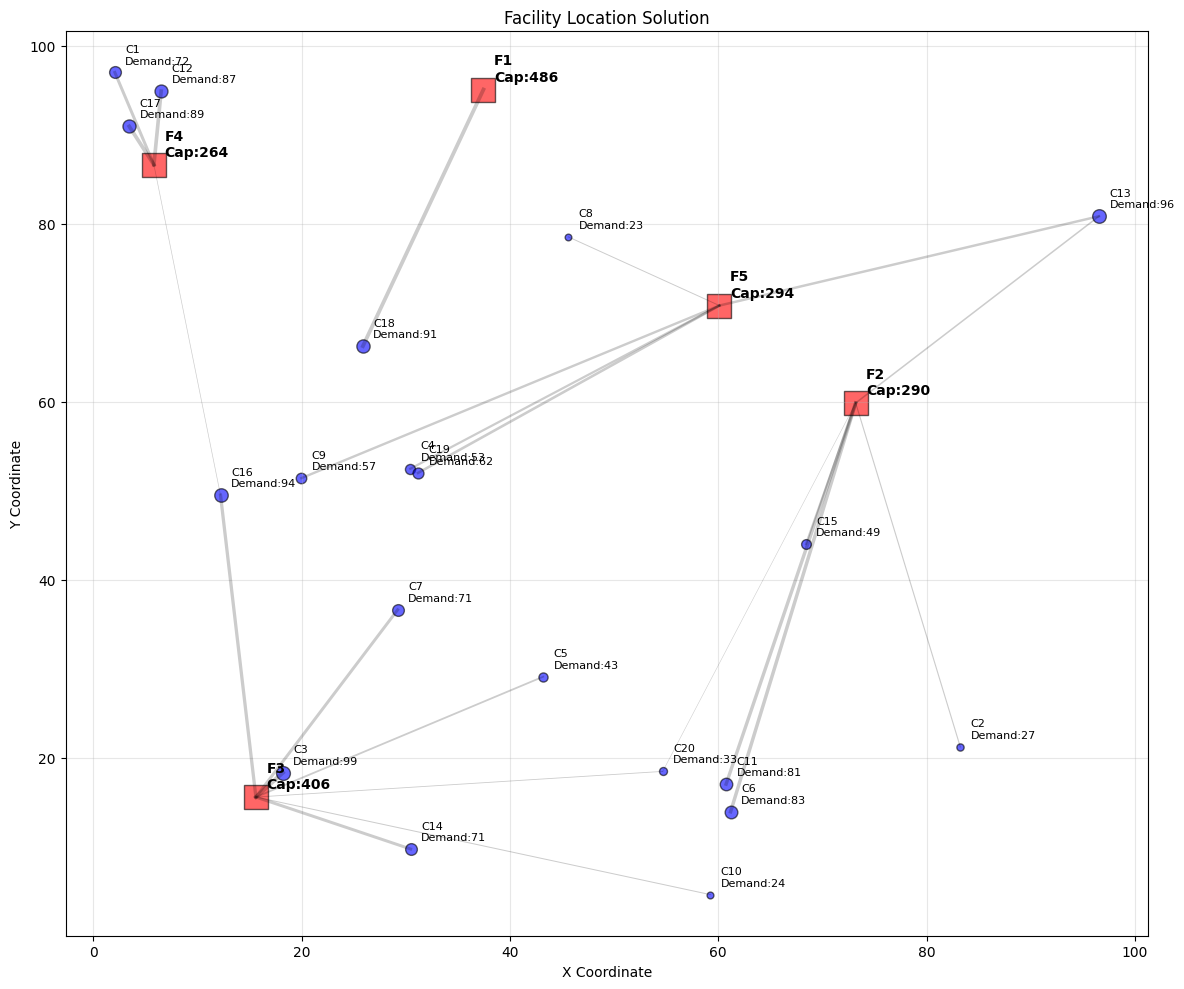

In [ ]:
# Constraints

# Meet customer demand
for j in range(n_customers):
    model += pl.lpSum([x[(i, j)] for i in range(n_facilities)]) == demands[j], f"Demand_{j}"

# Facility capacity constraint
for i in range(n_facilities):
    model += pl.lpSum([x[(i, j)] for j in range(n_customers)]) <= capacities[i] * y[i], f"Capacity_{i}"

# Constraint: can only ship from open facilities
for i in range(n_facilities):
    for j in range(n_customers):
        model += x[(i, j)] <= demands[j] * y[i], f"Open_{i}_{j}"

# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total Cost: ${pl.value(model.objective):.2f}")

# Print open facilities
print("\nOpen Facilities:")
for i in range(n_facilities):
    if y[i].value() > 0.5:
        print(f"Facility {i+1}: Capacity {capacities[i]}, Fixed Cost ${fixed_costs[i]}")

# Visualize the solution
plt.figure(figsize=(12, 10))

# Plot customers as circles
for j in range(n_customers):
    plt.scatter(
        customer_coords[j, 0],
        customer_coords[j, 1],
        s=demands[j],
        c='blue',
        alpha=0.6,
        edgecolors='black'
    )
    plt.text(
        customer_coords[j, 0] + 1,
        customer_coords[j, 1] + 1,
        f"C{j+1}\nDemand:{demands[j]}",
        fontsize=8
    )

# Plot facilities as squares (filled if open, empty if closed)
for i in range(n_facilities):
    if y[i].value() > 0.5:  # Open facility
        plt.scatter(
            facility_coords[i, 0],
            facility_coords[i, 1],
            s=300,
            marker='s',
            c='red',
            alpha=0.6,
            edgecolors='black'
        )
        plt.text(
            facility_coords[i, 0] + 1,
            facility_coords[i, 1] + 1,
            f"F{i+1}\nCap:{capacities[i]}",
            fontsize=10,
            fontweight='bold'
        )
    else:  # Closed facility
        plt.scatter(
            facility_coords[i, 0],
            facility_coords[i, 1],
            s=300,
            marker='s',
            facecolors='none',
            edgecolors='red'
        )
        plt.text(
            facility_coords[i, 0] + 1,
            facility_coords[i, 1] + 1,
            f"F{i+1} (closed)",
            fontsize=10
        )

# Draw lines for assignments
for i in range(n_facilities):
    for j in range(n_customers):
        if x[(i, j)].value() > 0:
            plt.plot(
                [facility_coords[i, 0], customer_coords[j, 0]],
                [facility_coords[i, 1], customer_coords[j, 1]],
                'k-', alpha=0.2, linewidth=x[(i, j)].value() / max(demands) * 3
            )

plt.title("Facility Location Solution")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Create a summary table
assignments = pd.DataFrame(columns=['Facility', 'Customer', 'Demand', 'Distance', 'Transportation Cost'])

for i in range(n_facilities):
    for j in range(n_customers):
        if x[(i, j)].value() > 0:
            assignments = pd.concat([assignments, pd.DataFrame({
                'Facility': [f"Facility {i+1}"],
                'Customer': [f"Customer {j+1}"],
                'Demand': [x[(i, j)].value()],
                'Distance': [distances[(i, j)]],
                'Transportation Cost': [distances[(i, j)] * x[(i, j)].value()]
            })], ignore_index=True)

print("\nAssignment Summary:")
print(assignments)


Assignment Summary:
      Facility     Customer  Demand   Distance  Transportation Cost
0   Facility 1  Customer 18    91.0  31.057213          2826.206427
1   Facility 2   Customer 2    27.0  39.916488          1077.745169
2   Facility 2   Customer 6    83.0  47.462198          3939.362424
3   Facility 2  Customer 11    81.0  44.585492          3611.424824
4   Facility 2  Customer 13    37.0  31.396998          1161.688928
5   Facility 2  Customer 15    49.0  16.554532           811.172084
6   Facility 2  Customer 20    13.0  45.339145           589.408889
7   Facility 3   Customer 3    99.0   3.764670           372.702331
8   Facility 3   Customer 5    43.0  30.728451          1321.323383
9   Facility 3   Customer 7    71.0  25.056875          1779.038156
10  Facility 3  Customer 10    24.0  44.993479          1079.843503
11  Facility 3  Customer 14    71.0  15.963087          1133.379193
12  Facility 3  Customer 16    78.0  34.088027          2658.866141
13  Facility 3  Customer 20

<ipython-input-23-045283f5eac4>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  assignments = pd.concat([assignments, pd.DataFrame({


In [ ]:
# Calculate and print facility utilization
print("\nFacility Utilization:")
for i in range(n_facilities):
    if y[i].value() > 0.5:
        utilization = sum(x[(i, j)].value() for j in range(n_customers)) / capacities[i] * 100
        print(f"Facility {i+1}: {utilization:.1f}% utilized")


Facility Utilization:
Facility 1: 18.7% utilized
Facility 2: 100.0% utilized
Facility 3: 100.0% utilized
Facility 4: 100.0% utilized
Facility 5: 86.4% utilized


## Case Study 4: Bin Packing Problem

In [ ]:
import pulp as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the optimization model
model = pl.LpProblem("Bin_Packing", pl.LpMinimize)

In [ ]:
# Parameters
n_items = 15
bin_capacity = 100

# Generate item weights (sizes)
np.random.seed(42)
item_weights = np.random.randint(20, 60, size=n_items)

# Maximum number of bins needed (worst case: one item per bin)
max_bins = n_items

# Decision variables
# Binary variable: whether to use bin j
y = {}
for j in range(max_bins):
    y[j] = pl.LpVariable(f"Use_Bin_{j}", cat='Binary')

# Binary variable: whether to put item i in bin j
x = {}
for i in range(n_items):
    for j in range(max_bins):
        x[(i, j)] = pl.LpVariable(f"Put_Item_{i}_In_Bin_{j}", cat='Binary')

# Objective function: minimize number of bins used
model += pl.lpSum([y[j] for j in range(max_bins)]), "Minimize_Bins"

# Constraints

# Each item must be in exactly one bin
for i in range(n_items):
    model += pl.lpSum([x[(i, j)] for j in range(max_bins)]) == 1, f"Item_{i}_Assignment"

# Bin capacity constraint
for j in range(max_bins):
    model += pl.lpSum([item_weights[i] * x[(i, j)] for i in range(n_items)]) <= bin_capacity * y[j], f"Bin_{j}_Capacity"

# Symmetry-breaking constraints to speed up solution
for j in range(1, max_bins):
    model += y[j] <= y[j-1], f"Symmetry_{j}"

Status: Optimal
Total bins needed: 7.0

Bin Packing Solution:
Bin 1 (Total Weight: 68/100):
  - Item 7: Weight 38
  - Item 9: Weight 30
Bin 2 (Total Weight: 98/100):
  - Item 11: Weight 43
  - Item 12: Weight 55
Bin 3 (Total Weight: 98/100):
  - Item 5: Weight 40
  - Item 6: Weight 58
Bin 4 (Total Weight: 82/100):
  - Item 2: Weight 48
  - Item 3: Weight 34
Bin 5 (Total Weight: 89/100):
  - Item 10: Weight 30
  - Item 13: Weight 59
Bin 6 (Total Weight: 100/100):
  - Item 1: Weight 58
  - Item 8: Weight 42
Bin 7 (Total Weight: 92/100):
  - Item 4: Weight 27
  - Item 14: Weight 43
  - Item 15: Weight 22


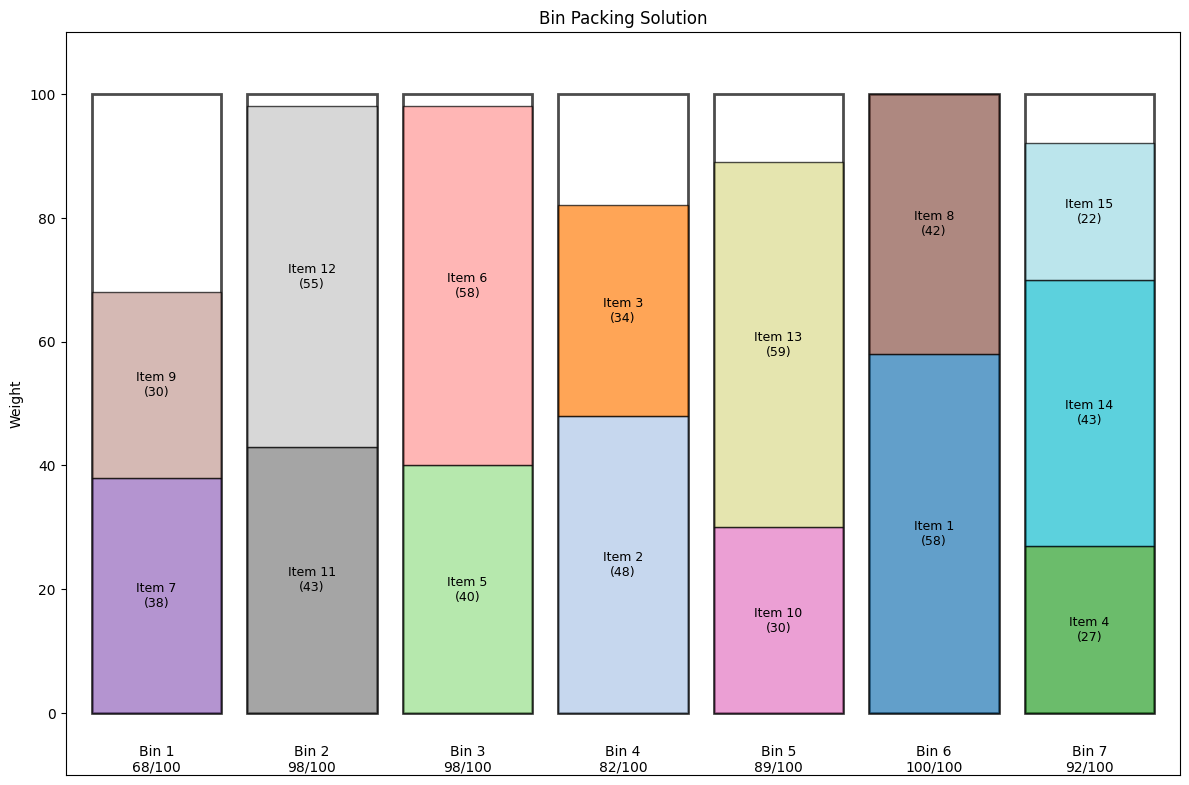

In [ ]:
# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total bins needed: {pl.value(model.objective)}")

# Get the solution
bins_used = []
for j in range(max_bins):
    if y[j].value() > 0.5:
        items_in_bin = []
        bin_weight = 0
        for i in range(n_items):
            if x[(i, j)].value() > 0.5:
                items_in_bin.append((i, item_weights[i]))
                bin_weight += item_weights[i]
        bins_used.append((j, items_in_bin, bin_weight))

# Print the solution
print("\nBin Packing Solution:")
for j, items, weight in bins_used:
    print(f"Bin {j+1} (Total Weight: {weight}/{bin_capacity}):")
    for i, w in items:
        print(f"  - Item {i+1}: Weight {w}")

# Visualize the solution
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for items
colors = plt.cm.tab20(np.linspace(0, 1, n_items))

# Draw bins
bin_width = 1
bin_spacing = 0.2
bin_x_positions = np.arange(len(bins_used)) * (bin_width + bin_spacing)

for idx, (j, items, weight) in enumerate(bins_used):
    # Draw bin outline
    rect = patches.Rectangle(
        (bin_x_positions[idx], 0), bin_width, bin_capacity,
        linewidth=2, edgecolor='black', facecolor='none', alpha=0.7
    )
    ax.add_patch(rect)

    # Label bin
    ax.text(
        bin_x_positions[idx] + bin_width/2, -5,
        f"Bin {j+1}\n{weight}/{bin_capacity}",
        ha='center', va='top'
    )

    # Draw items in the bin
    current_height = 0
    for i, w in items:
        rect = patches.Rectangle(
            (bin_x_positions[idx], current_height), bin_width, w,
            linewidth=1, edgecolor='black', facecolor=colors[i], alpha=0.7
        )
        ax.add_patch(rect)

        # Item label
        ax.text(
            bin_x_positions[idx] + bin_width/2, current_height + w/2,
            f"Item {i+1}\n({w})",
            ha='center', va='center', fontsize=9
        )

        current_height += w

# Set plot limits
ax.set_xlim(-bin_spacing, max(bin_x_positions) + bin_width + bin_spacing)
ax.set_ylim(-10, bin_capacity + 10)

# Set ticks and labels
ax.set_xticks([])
ax.set_ylabel('Weight')
ax.set_title('Bin Packing Solution')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate statistics
utilization = [weight/bin_capacity * 100 for _, _, weight in bins_used]
print(f"\nAverage bin utilization: {np.mean(utilization):.1f}%")
print(f"Minimum bin utilization: {np.min(utilization):.1f}%")
print(f"Maximum bin utilization: {np.max(utilization):.1f}%")


Average bin utilization: 89.6%
Minimum bin utilization: 68.0%
Maximum bin utilization: 100.0%


## Case Study 5: Diet Problem

In [ ]:
import pulp as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create the optimization model
model = pl.LpProblem("Diet_Problem", pl.LpMinimize)

# Food data: name, cost, calories, protein, fat, carbs, fiber, vitamin_a, vitamin_c
foods_data = [
    ("Oatmeal", 2.5, 150, 6, 2.5, 27, 4, 0, 0),
    ("Chicken Breast", 4.5, 165, 31, 3.6, 0, 0, 0, 0),
    ("Eggs", 3.0, 70, 6, 5, 0, 0, 5, 0),
    ("Whole Milk", 2.0, 150, 8, 8, 12, 0, 10, 2),
    ("Broccoli", 1.8, 55, 4, 0, 11, 5, 15, 135),
    ("Banana", 0.6, 105, 1, 0, 27, 3, 1, 10),
    ("Whole Wheat Bread", 2.0, 80, 4, 1, 15, 2, 0, 0),
    ("Spinach", 1.5, 20, 2, 0, 3, 2, 60, 10),
    ("Lentils", 1.0, 115, 9, 0, 20, 8, 0, 3),
    ("Salmon", 6.0, 200, 22, 12, 0, 0, 0, 0),
    ("Greek Yogurt", 2.5, 130, 12, 4, 5, 0, 0, 0),
    ("Sweet Potato", 1.2, 115, 2, 0, 27, 4, 120, 30),
    ("Almonds", 5.0, 170, 6, 15, 6, 3, 0, 0),
    ("Brown Rice", 1.0, 110, 2, 1, 22, 2, 0, 0),
    ("Avocado", 2.2, 240, 3, 22, 12, 10, 0, 15)
]

In [ ]:
# Create a dataframe for better visualization
food_df = pd.DataFrame(foods_data, columns=[
    'Food', 'Cost', 'Calories', 'Protein', 'Fat', 'Carbs', 'Fiber', 'Vitamin_A', 'Vitamin_C'
])

# Nutritional requirements (min and max values)
requirements = {
    'Calories': (1800, 2200),
    'Protein': (50, 100),
    'Fat': (20, 65),
    'Carbs': (130, 300),
    'Fiber': (25, 50),
    'Vitamin_A': (90, 3000),  # micrograms RAE
    'Vitamin_C': (75, 2000)   # milligrams
}

In [ ]:
# Decision variables - how much of each food to include
x = {}
for i, (food, _, _, _, _, _, _, _, _) in enumerate(foods_data):
    x[i] = pl.LpVariable(f"Eat_{food}", lowBound=0, cat='Continuous')

# Objective function - minimize cost
model += pl.lpSum([foods_data[i][1] * x[i] for i in range(len(foods_data))]), "Total_Cost"

# Constraints - meet nutritional requirements
# Calories
model += pl.lpSum([foods_data[i][2] * x[i] for i in range(len(foods_data))]) >= requirements['Calories'][0], "Min_Calories"
model += pl.lpSum([foods_data[i][2] * x[i] for i in range(len(foods_data))]) <= requirements['Calories'][1], "Max_Calories"

# Protein
model += pl.lpSum([foods_data[i][3] * x[i] for i in range(len(foods_data))]) >= requirements['Protein'][0], "Min_Protein"
model += pl.lpSum([foods_data[i][3] * x[i] for i in range(len(foods_data))]) <= requirements['Protein'][1], "Max_Protein"

# Fat
model += pl.lpSum([foods_data[i][4] * x[i] for i in range(len(foods_data))]) >= requirements['Fat'][0], "Min_Fat"
model += pl.lpSum([foods_data[i][4] * x[i] for i in range(len(foods_data))]) <= requirements['Fat'][1], "Max_Fat"

# Carbs
model += pl.lpSum([foods_data[i][5] * x[i] for i in range(len(foods_data))]) >= requirements['Carbs'][0], "Min_Carbs"
model += pl.lpSum([foods_data[i][5] * x[i] for i in range(len(foods_data))]) <= requirements['Carbs'][1], "Max_Carbs"

# Fiber
model += pl.lpSum([foods_data[i][6] * x[i] for i in range(len(foods_data))]) >= requirements['Fiber'][0], "Min_Fiber"
model += pl.lpSum([foods_data[i][6] * x[i] for i in range(len(foods_data))]) <= requirements['Fiber'][1], "Max_Fiber"

# Vitamin A
model += pl.lpSum([foods_data[i][7] * x[i] for i in range(len(foods_data))]) >= requirements['Vitamin_A'][0], "Min_Vitamin_A"
model += pl.lpSum([foods_data[i][7] * x[i] for i in range(len(foods_data))]) <= requirements['Vitamin_A'][1], "Max_Vitamin_A"

# Vitamin C
model += pl.lpSum([foods_data[i][8] * x[i] for i in range(len(foods_data))]) >= requirements['Vitamin_C'][0], "Min_Vitamin_C"
model += pl.lpSum([foods_data[i][8] * x[i] for i in range(len(foods_data))]) <= requirements['Vitamin_C'][1], "Max_Vitamin_C"

# Additional constraints for variety (optional)
# Ensure we eat at least 0.1 servings of at least 10 different foods
for i in range(len(foods_data)):
    y = pl.LpVariable(f"Include_{foods_data[i][0]}", cat='Binary')
    model += x[i] >= 0.1 * y, f"Min_Serving_{foods_data[i][0]}"

model += pl.lpSum([y for i, (food, _, _, _, _, _, _, _, _) in enumerate(foods_data) for food_idx, food_name in enumerate([food]) for var_name, y in model.variablesDict().items() if var_name == f"Include_{food}"]) >= 10, "Min_Variety"

In [ ]:
# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total Daily Food Cost: ${pl.value(model.objective):.2f}")

# Get the optimal diet
diet = []
for i, (food, cost, calories, protein, fat, carbs, fiber, vitamin_a, vitamin_c) in enumerate(foods_data):
    amount = x[i].value()
    if amount > 0.01:  # Only include foods with non-zero amounts
        diet.append({
            'Food': food,
            'Amount': amount,
            'Cost': cost * amount,
            'Calories': calories * amount,
            'Protein': protein * amount,
            'Fat': fat * amount,
            'Carbs': carbs * amount,
            'Fiber': fiber * amount,
            'Vitamin_A': vitamin_a * amount,
            'Vitamin_C': vitamin_c * amount
        })

Status: Infeasible
Total Daily Food Cost: $16.99


In [ ]:
# Create a dataframe for the diet
diet_df = pd.DataFrame(diet)
print("\nOptimal Diet:")
print(diet_df[['Food', 'Amount', 'Cost']].sort_values('Amount', ascending=False))

# Calculate nutritional totals
totals = {
    'Calories': diet_df['Calories'].sum(),
    'Protein': diet_df['Protein'].sum(),
    'Fat': diet_df['Fat'].sum(),
    'Carbs': diet_df['Carbs'].sum(),
    'Fiber': diet_df['Fiber'].sum(),
    'Vitamin_A': diet_df['Vitamin_A'].sum(),
    'Vitamin_C': diet_df['Vitamin_C'].sum()
}

print("\nNutritional Totals:")
for nutrient, total in totals.items():
    min_val, max_val = requirements[nutrient]
    print(f"{nutrient}: {total:.1f} (Requirement: {min_val}-{max_val})")

# Visualize the diet
plt.figure(figsize=(15, 10))


Optimal Diet:
            Food    Amount      Cost
4         Banana  7.836608  4.701965
2     Whole Milk  2.596379  5.192757
10       Avocado  1.296052  2.851314
6        Lentils  1.277876  1.277876
8   Sweet Potato  0.401663  0.481996
9        Almonds  0.200000  1.000000
0        Oatmeal  0.100000  0.250000
1           Eggs  0.100000  0.300000
3       Broccoli  0.100000  0.180000
5        Spinach  0.100000  0.150000
7         Salmon  0.100000  0.600000

Nutritional Totals:
Calories: 1800.0 (Requirement: 1800-2200)
Protein: 50.0 (Requirement: 50-100)
Fat: 54.2 (Requirement: 20-65)
Carbs: 300.0 (Requirement: 130-300)
Fiber: 50.0 (Requirement: 25-50)
Vitamin_A: 90.0 (Requirement: 90-3000)
Vitamin_C: 133.4 (Requirement: 75-2000)


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

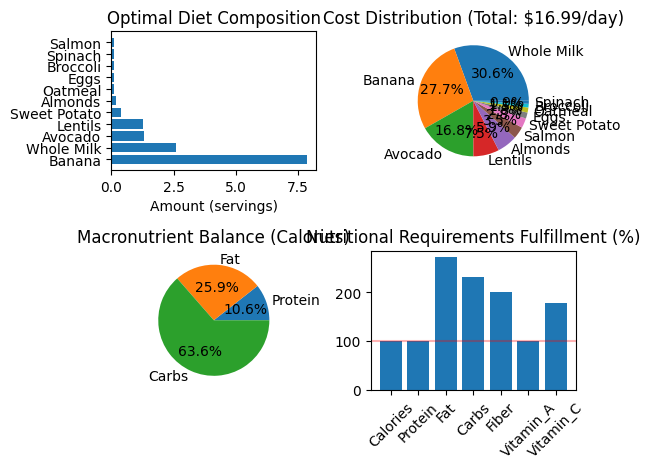


Shadow Prices (Sensitivity Analysis):
Min_Serving_Almonds: 2.9600905
Min_Serving_Salmon: 2.4705557
Min_Serving_Eggs: 1.8348845
Min_Serving_Broccoli: 1.3700539
Min_Serving_Oatmeal: 1.1626842
Min_Serving_Spinach: 1.0831227
Min_Variety: 0.29600905
Max_Fiber: -0.055402689
Min_Protein: 0.053256997
Max_Carbs: -0.019591047
Min_Calories: 0.011788952
Min_Vitamin_A: 0.0040693796


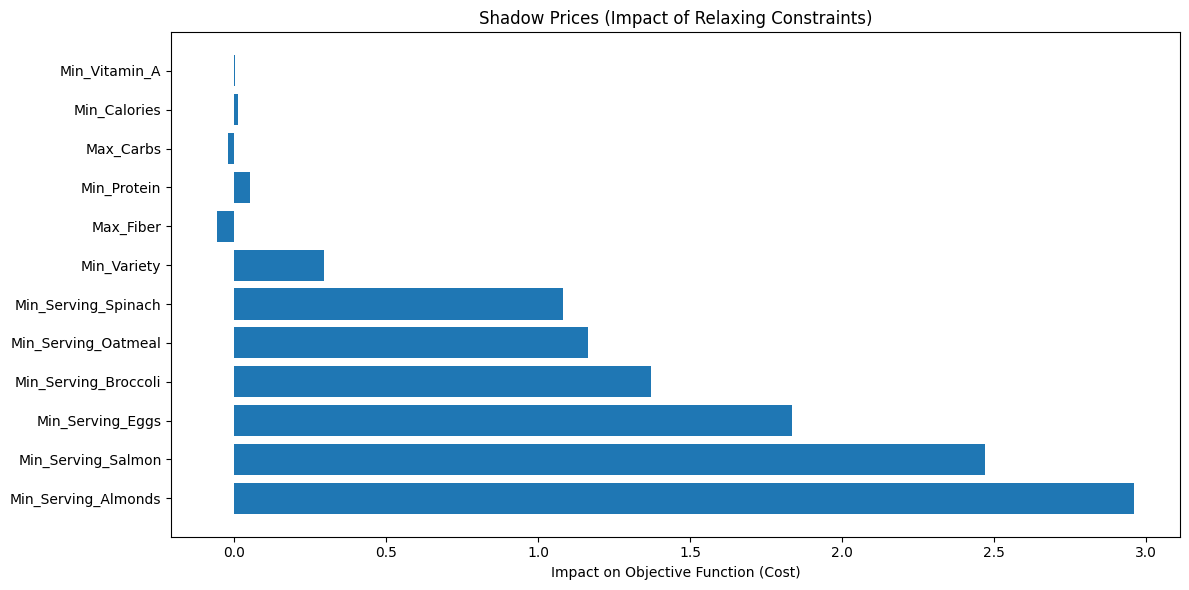

In [ ]:
# Plot 1: Food Composition
plt.subplot(2, 2, 1)
selected_foods = diet_df.sort_values('Amount', ascending=False)['Food'].values
selected_amounts = diet_df.sort_values('Amount', ascending=False)['Amount'].values

plt.barh(selected_foods, selected_amounts)
plt.title('Optimal Diet Composition')
plt.xlabel('Amount (servings)')
plt.tight_layout()

# Plot 2: Cost Distribution
plt.subplot(2, 2, 2)
cost_data = diet_df.sort_values('Cost', ascending=False)
plt.pie(cost_data['Cost'], labels=cost_data['Food'], autopct='%1.1f%%')
plt.title(f'Cost Distribution (Total: ${pl.value(model.objective):.2f}/day)')

# Plot 3: Macronutrient Balance
plt.subplot(2, 2, 3)
macros = ['Protein', 'Fat', 'Carbs']
macro_values = [totals[nutrient] for nutrient in macros]
macro_calories = [totals['Protein'] * 4, totals['Fat'] * 9, totals['Carbs'] * 4]  # Convert to calories
plt.pie(macro_calories, labels=macros, autopct='%1.1f%%')
plt.title('Macronutrient Balance (Calories)')

# Plot 4: Nutritional Requirements Fulfillment
plt.subplot(2, 2, 4)
fulfillment = []
nutrients = list(requirements.keys())

for nutrient in nutrients:
    min_val, max_val = requirements[nutrient]
    total = totals[nutrient]
    # Calculate fulfillment percentage (100% means at minimum requirement, >100% means exceeding minimum)
    if min_val > 0:
        fulfillment.append(total / min_val * 100)
    else:
        fulfillment.append(100)  # Avoid division by zero

plt.bar(nutrients, fulfillment)
plt.axhline(y=100, color='r', linestyle='-', alpha=0.3)
plt.title('Nutritional Requirements Fulfillment (%)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.tight_layout()
plt.show()

# Sensitivity Analysis
print("\nShadow Prices (Sensitivity Analysis):")
shadow_prices = {}
for name, constraint in model.constraints.items():
    if constraint.pi != 0:
        shadow_prices[name] = constraint.pi

# Sort shadow prices by absolute value
shadow_prices = {k: v for k, v in sorted(shadow_prices.items(), key=lambda item: abs(item[1]), reverse=True)}

for constraint, value in shadow_prices.items():
    print(f"{constraint}: {value}")

# Visualize shadow prices
plt.figure(figsize=(12, 6))
plt.barh(list(shadow_prices.keys()), list(shadow_prices.values()))
plt.title('Shadow Prices (Impact of Relaxing Constraints)')
plt.xlabel('Impact on Objective Function (Cost)')
plt.tight_layout()
plt.show()